# Example for Online Linear Regression

In [1]:
from pykalman import KalmanFilter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import poly1d
%matplotlib inline

EM Algorithm for a Linear Gaussian model specified by
$$x_0 = Normal(\mu_0, \Sigma_0)$$
$$x_{t+1} = A x_{t} + b_t + Normal(0,Q_t)$$
$$z_t = C x_t + d_t + Normal(0,R_t)$$

In [2]:
tau = 0.1

# Set up the filter
kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # position is 1-dimensional, (x,v) is 2-dimensional
                  initial_state_mean=[30,10],
                  initial_state_covariance=np.eye(2),
                  transition_matrices=[[1,tau], [0,1]],
                  observation_matrices=[[1,0]],
                  observation_covariance=3,
                  transition_covariance=np.zeros((2,2)),
                  transition_offsets=[-4.9*tau**2, -9.8*tau])

In [3]:
actual = np.array([-4.9*(tau*n)**2 for n in range(40)])
cameral = actual + np.random.randn(40)*3
state_means,state_cov = kf.filter(cameral)

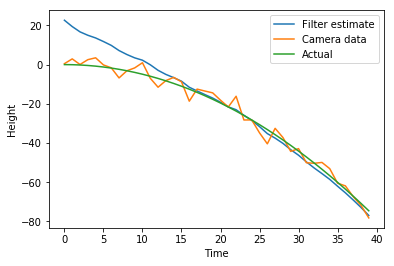

In [4]:
times = [n for n in range(40)]
plt.plot(times, state_means[:,0])
plt.plot(times, cameral)
plt.plot(times, actual)
plt.legend(['Filter estimate', 'Camera data', 'Actual'])
plt.xlabel('Time')
plt.ylabel('Height');

We can use a Kalman filter to model non-linear transition and observation functions, as well. For this purpose there exist extended and unscented Kalman filters, the latter of which is included in pykalman. These can even model situations where noise is not additive (for example, where noise is proportional to the size of the measurement). We can also specify non-Gaussian errors; this is useful in financial data, which tends to have heavy-tailed distributions.

Beta hedge: How to hedge your algorithm against your risk factors

# Stock Price Prediction Using Kalman Filter

In [5]:
from rqdata_utils import *
import pandas
import numpy as np
import scipy as sp
import alphalens as al
from pykalman import KalmanFilter
%matplotlib inline

In [6]:
price_df,instrument_df,equity_df = get_price_instrument_equity("cn_stock_price_2012_2018.csv","cn_instrument_info_2012_2018.csv","cn_equity_daily_2012_2018.csv","sectorCode")

In [7]:
healthcareUniverse = instrument_df.index[instrument_df.sectorCode=='HealthCare'].values
len(healthcareUniverse)

164

In [8]:
def equity_universe_filtering(equity_df, universe):
    universeFilter = [book_id in set(universe) for book_id in equity_df.index.get_level_values(level=1).values]
    return equity_df[universeFilter]

In [9]:
healthcare_equity_df = equity_universe_filtering(equity_df, healthcareUniverse)
healthcare_equity_df.head()

return    close  total_turnover     volume  \
date       order_book_id                                                 
2012-01-04 000004.XSHE   -0.022250   7.9100      3763832.88   465469.0   
           000028.XSHE   -0.045433  19.8422      9326924.28   450553.0   
           000150.XSHE   -0.030295   3.1737      3109304.50   952600.0   
           000153.XSHE   -0.028053   5.7700      9673054.49  1596020.0   
           000403.XSHE    0.000000   3.1625            0.00        0.0   

                            week   month report_quarter    market_cap  \
date       order_book_id                                                
2012-01-04 000004.XSHE    0.5720  0.7506         2011q3  6.642556e+08   
           000028.XSHE    0.4201  0.2722         2011q3  5.872485e+09   
           000150.XSHE    0.3460  0.3610         2011q3  1.036800e+09   
           000153.XSHE    0.6830  2.4594         2011q3  1.531454e+09   
           000403.XSHE    0.0000  0.0000            NaN           NaN   

                          a_share_market_val_2  \
date       order_book_id                         
2012-01-04 000004.XSHE            6.634549e+08   
           000028.XSHE            4.753820e+09   
           000150.XSHE            1.036800e+09   
           000153.XSHE            1.360856e+09   
           000403.XSHE                     NaN   

                          cash_received_from_sales_of_goods  pb_ratio  \
date       order_book_id                                                
2012-01-04 000004.XSHE                         5.949968e+07    8.8175   
           000028.XSHE                         1.053298e+10    4.3493   
           000150.XSHE                         4.913279e+07    1.4763   
           000153.XSHE                         1.329425e+09    2.1169   
           000403.XSHE                                  NaN       NaN   

                            net_profit  ps_ratio  sectorCode  
date       order_book_id                                      
2012-01-04 000004.XSHE    4.500363e+06   37.5796  HealthCare  
           000028.XSHE    2.481834e+08    0.3414  HealthCare  
           000150.XSHE    3.657858e+06    7.8956  HealthCare  
           000153.XSHE    1.560397e+07    0.7818  HealthCare  
           000403.XSHE             NaN       NaN  HealthCare

In [10]:
benchmark_df = pd.read_csv("cn_SH_healthcare_index_2012_2018.csv",names=['date','value'])
benchmark_df = benchmark_df.set_index('date',drop=True)
benchmark_df['return'] = np.log(benchmark_df.shift(1)/benchmark_df).fillna(0)
benchmark_df.head()

,value,return
date,,
2012-01-04,2891.462,0.000000
2012-01-05,2766.955,0.044015
2012-01-06,2744.793,0.008042
2012-01-09,2833.219,-0.031708
2012-01-10,2929.594,-0.033450


In [103]:
healthcare_equity_df['market_cap'].fillna(0).head()

date        order_book_id
2012-01-04  000004.XSHE      6.642556e+08
            000028.XSHE      5.872485e+09
            000150.XSHE      1.036800e+09
            000153.XSHE      1.531454e+09
            000403.XSHE      0.000000e+00
Name: market_cap, dtype: float64

In [107]:
factor_list = ['market_cap', 'pb_ratio', 'ps_ratio']
factor_size = len(factor_list)

data_copy = healthcare_equity_df[factor_list].fillna(0)
factor_zscore = (data_copy - data_copy.groupby(level='date').mean())/data_copy.groupby(level='date').std()
factor_zscore.head()

market_cap  pb_ratio  ps_ratio
date       order_book_id                                
2012-01-04 000004.XSHE     -0.784393 -0.115692  4.830427
           000028.XSHE     -0.093343 -0.124286 -0.672507
           000150.XSHE     -0.734962 -0.129812  0.443827
           000153.XSHE     -0.669329 -0.128580 -0.607426
           000403.XSHE     -0.872529 -0.132652 -0.722958

In [124]:
idx = pandas.IndexSlice

healthcare_subset = set(healthcareUniverse)

for date,group in factor_zscore.groupby(level=0):
#     print(size)
    size = group.shape[0]
#     print(date,size)
#     print(group)
    new_set = set(group.loc[idx[:,healthcare_subset],:].index.get_level_values(1).values)
    if(new_set<healthcare_subset):
        healthcare_subset = new_set
#         print(healthcare_subset)
        
asset_size = len(healthcare_subset)
print(asset_size)
observation_transition_matrix = []
for date,group in factor_zscore.groupby(level=0):
    exposure_matrix = group.loc[idx[:,healthcare_subset],:].values
#     print(np.shape(exposure_matrix))
#     print(exposure_matrix.shape)
#     print(healthcare_size)
    observation_transition_matrix.append(np.concatenate((np.eye(asset_size),exposure_matrix),axis=1).tolist())


63
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 

(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)
(63, 3)


In [83]:
observations = healthcare_equity_df.loc[pd.IndexSlice[:,healthcare_subset],'return']

In [115]:
observation_list = []
for date,group in observations.groupby(level=0):
    observation_list.append(group.values.tolist())

In [129]:
np.shape(observation_transition_matrix)

(1535, 63, 66)

In [131]:
state_transition_matrix = np.eye(factor_size+asset_size)
state_covariance_matrix = np.eye(factor_size+asset_size)*0.1
observation_matrices = observation_transition_matrix
observation_covariance_matrix = np.eye(asset_size)*0.1
initial_state_mean = np.zeros(factor_size+asset_size)
initial_state_covariance = np.eye(factor_size+asset_size)*0.1


nstate = factor_size+asset_size
nobs = asset_size
print(state_transition_matrix.shape)
print(state_covariance_matrix.shape)
print(np.shape(observation_matrices))
print(observation_covariance_matrix.shape==(nobs,nobs))
print(initial_state_mean.shape==(nstate,))
print(initial_state_covariance.shape==(nstate,nstate))


kf = KalmanFilter(transition_matrices=state_transition_matrix,
                 transition_covariance=state_covariance_matrix,
                 observation_matrices=observation_matrices,
                 observation_covariance=observation_covariance_matrix,
                 initial_state_mean=initial_state_mean,
                 initial_state_covariance=initial_state_covariance,
                 n_dim_state=nstate,
                 n_dim_obs=nobs)

(66, 66)
(66, 66)
(1535, 63, 66)
True
True
True


In [132]:
returns = kf.filter(observation_list)

In [134]:
filtered_state_means = returns[0]

array([[-0.0201041 , -0.0211423 , -0.01611745, ..., -0.00171038,
         0.00708199,  0.0036095 ],
       [-0.05609598, -0.045082  , -0.02782665, ...,  0.00387021,
        -0.00058306,  0.00203373],
       [-0.02882871, -0.03163535, -0.01248095, ...,  0.00289151,
        -0.00037338,  0.00385506],
       ..., 
       [-0.02064002, -0.01950058,  0.01873337, ...,  0.277321  ,
         0.06993532, -0.00129205],
       [-0.0262313 , -0.03301924,  0.02124976, ...,  0.27846191,
         0.0737237 , -0.00576752],
       [-0.01205274, -0.00491581,  0.02945286, ...,  0.28587637,
         0.06616954,  0.00036902]])

## Time-series Regression
From APT theory, we assume the sources of the randomness are factor returns. Which means factor exposure $\beta$ is a constant for each (asset, factor) pair and doesn't depend on time. Here, we assume that we already know the 

In [135]:
# import statsmodels.api as sm
# from statsmodels import regression,stats


# factor_zscore = sm.add_constant(factor_zscore.dropna())

# Y = [healthcare_equity_df.xs(asset,level=1)['return'] for asset in healthcare_subset]
# X = [factor_zscore.xs(asset,level=1)[['market_cap','pb_ratio','ps_ratio','const']] for asset in healthcare_subset]
# reg_results = [regression.linear_model.OLS(y,x).fit().params for y,x in zip(Y,X) if not(x.empty or y.empty)]
# indices = [asset for y, x, asset in zip(Y, X, healthcare_subset) if not(x.empty or y.empty)]
# betas = pd.DataFrame(reg_results, index=indices)

In [137]:
betas.head()

,market_cap,pb_ratio,ps_ratio,const
000590.XSHE,0.021791,0.000574,0.003213,0.012693
000788.XSHE,0.005766,0.012097,0.003404,0.003217
600267.XSHG,0.005461,-0.007124,-0.001684,-0.004844
000989.XSHE,-0.003066,-0.001685,0.000733,0.000091
600750.XSHG,0.001438,0.000953,0.001284,0.001509


## Cross-sectional Regression
Here, we asseme the 

In [138]:
import statsmodels.api as sm
from statsmodels import regression,stats


factor_zscore = sm.add_constant(factor_zscore.dropna())
print(factor_zscore.head())

# Y = [healthcare_equity_df.xs(asset,level=1)['return'] for asset in healthcare_subset]
# X = [factor_zscore.xs(asset,level=1)[['market_cap','pb_ratio','ps_ratio','const']] for asset in healthcare_subset]
# reg_results = [regression.linear_model.OLS(y,x).fit().params for y,x in zip(Y,X) if not(x.empty or y.empty)]
# indices = [asset for y, x, asset in zip(Y, X, healthcare_subset) if not(x.empty or y.empty)]
# betas = pd.DataFrame(reg_results, index=indices)

                          const  market_cap  pb_ratio  ps_ratio
date       order_book_id                                       
2012-01-04 000004.XSHE      1.0   -0.784393 -0.115692  4.830427
           000028.XSHE      1.0   -0.093343 -0.124286 -0.672507
           000150.XSHE      1.0   -0.734962 -0.129812  0.443827
           000153.XSHE      1.0   -0.669329 -0.128580 -0.607426
           000403.XSHE      1.0   -0.872529 -0.132652 -0.722958


In [1]:
date= '2012-01-04'
factor_zscore[date]

NameError: name 'factor_zscore' is not defined